In [1]:
#########
import torch
# import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import CP1D as CP1
import diffprivlib as dpl
import Other_Mean_Algs as OMA
import P_Trimed_Mean as PTA
from tqdm import tqdm
import itertools
import pickle
import os
import scipy.stats
import seaborn as sns

           0          1
0   6.752682   5.100246
1   5.276144   4.802026
2  19.112570  18.764271
3   4.664253   4.135919
4   5.888885   3.691685


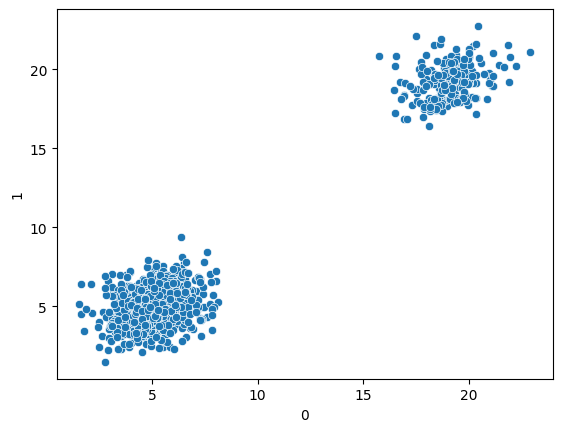

In [2]:
############ 


# get_cov(2).norm()
## Generate the datasets and set parameters
ns=[50,100,500,1000]
# ns=[50,100,200,300]
# rhos=[0.1,0.5,1,10,100]
rhos=[0.1,0.5,1]
Types=[1,2,3,4,5]
num_runs=250
# num_runs=1000
# num_runs=25

# Generate random covariance 
def get_cov(d):
    Sigma_k = torch.rand(d,d)
    Sigma_k = torch.mm(Sigma_k, Sigma_k.t())
    Sigma_k.add_(torch.eye(d))
    # D=torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))
    # A=D.sample(torch.Size([d]))
    # # print(A.shape)
    # S=A @ A.t()
    # S=OMA.psd_proj_symm(S)
    return d*Sigma_k/Sigma_k.norm()

# Gen random data 
# 1. Normal, 2. Mixture, 3. Skew, 4. Heavy tail, 5. Contamination
def generate_data(Type,n,d,eta=0.2):
    if Type==1:
        D=torch.distributions.MultivariateNormal(torch.zeros(d), get_cov(d))
        X=D.sample(torch.Size([n]))
    elif Type==2:
        mix = torch.distributions.Categorical(torch.ones(2,))
        # Stack the means and covariances to define the component distributions
        component_means = torch.stack([torch.zeros(d)-5,torch.zeros(d)+5])
        component_covariances = torch.stack([ get_cov(d), get_cov(d)])
        component_distributions = torch.distributions.MultivariateNormal(component_means, component_covariances)
        D = torch.distributions.MixtureSameFamily(mix, component_distributions)
        X=D.sample(torch.Size([n]))
    elif Type==3:
        D = torch.distributions.Exponential(torch.tensor([1.0]))
        X=D.sample(torch.Size((n,d)))-1
    elif Type==4:
        D=torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))
        A=D.sample((d,))
        D = torch.distributions.StudentT(df=3.0)
        X= D.sample(torch.Size((n,d))) @ A.t()
    elif Type==5:
        D=torch.distributions.MultivariateNormal(torch.zeros(d), get_cov(d))
        X=D.sample(torch.Size([n]))
        X[0:int(n*eta),:]=X[0:int(n*eta),:]+10*np.sqrt(d)
        X=X[torch.randperm(n),:] 
    # elif Type==6:
    #     D = torch.distributions.Exponential(torch.tensor([1.0]))
    #     X=D.sample(torch.Size((n,d)))-1
    #     X[0:int(n*eta),:]=X[0:int(n*eta),:]+10*np.sqrt(d)
    #     X=X[torch.randperm(n),:] 
    return X


X=generate_data(2,1000,2,eta=0.2)+5
X=generate_data(5,1000,2,eta=0.2)+5
X=torch.squeeze(X)
df=pd.DataFrame(X)
print(df.head())
sns.scatterplot(data=df,x=0,y=1)
plt.show()
# sns.histplot(data=df,x=0,y=1)
# plt.show()
# plt.plot(X)
# print(df.head())

In [3]:
def one_run(n,d,rho,Type,seed=1):
    torch.manual_seed(seed)
    X=generate_data(Type,n,d,eta=0.2)+5
    radius=50
    X=X.numpy()
    rng=np.random.default_rng(seed=seed)
    top=int(np.min((100,int(0.05*n))))
    constant=rng.integers(low=1, high=top, size=1)
    ## Private trimmed mean
    tm1=PTA.private_tm_zCDP_mod_1(X, -radius,radius,rho/4,rho/4,rho/2,beta=1.001,constant=constant,eta=0,seed=seed)
    tm_c1=PTA.private_tm_zCDP_mod_1(X, -radius,radius,rho/4,rho/4,rho/2,beta=1.001,constant=constant,eta=0.3,seed=seed)
    tm_theo=PTA.private_tm_zCDP(X, -radius,radius,rho/4,rho/4,rho/2,beta=1.001,constant=constant,eta=0,seed=seed)
    tm_theo_c=PTA.private_tm_zCDP(X, -radius,radius,rho/4,rho/4,rho/2,beta=1.001,constant=constant,eta=0.3,seed=seed)

    ## BUN
    bun0=OMA.bun_2019(X, -radius,radius, rho,m=constant[0],t=0.01,seed=seed)
    bun1=OMA.bun_2019(X, -radius,radius, rho,m=constant[0],t=0.1,seed=seed)
    bun2=OMA.bun_2019(X, -radius,radius, rho,m=constant[0],t=0.2,seed=seed)
    bun3=OMA.bun_2019(X, -radius,radius, rho,m=constant[0],t=0.3,seed=seed)
    bun4=OMA.bun_2019(X, -radius,radius, rho,m=constant[0],t=0.5,seed=seed)
    bun5=OMA.bun_2019(X, -radius,radius, rho,m=constant[0],t=0.7,seed=seed)
    bun6=OMA.bun_2019(X, -radius,radius, rho,m=constant[0],t=0.9,seed=seed)
    bun7=OMA.bun_2019(X, -radius,radius, rho,m=constant[0],t=1,seed=seed)
    ## Duchi
    # 
    duchi=OMA.duchi_2014(X, -radius,radius,rho)    
    ## Kamath
    kam=OMA.CPDPMean(X,1,radius,rho,beta=0.1)
    cp=CP1.COINPRESS1D(torch.from_numpy(X).float() ,n,1,rho,torch.zeros(1),radius,50.0 )[0].numpy()
    return [tm1,tm_c1,tm_theo,tm_theo_c,duchi,kam,cp[0],bun0,bun1,bun2,bun3,bun4,bun5,bun6,bun7]

rng=np.random.default_rng()
c=rng.integers(low=1, high=1000, size=1)
one_run(1000,1,5,1,c)

[4.982862363614033,
 4.980027959917472,
 5.01184203298368,
 4.974483365201035,
 4.587958070031124,
 4.901470725953635,
 4.9802184,
 4.993019201845712,
 4.983912725169882,
 4.98382146903672,
 4.983747114582495,
 4.983652238554233,
 4.9836556853469824,
 4.983658609907799,
 4.983660048368387]

In [4]:
total=len(ns)*len(rhos)*5
count=0
for n in ns:
    print(count/total)
    for rho1 in range(0,3):
        rho=rhos[rho1]
        for Type in Types:
            mean_ests=[]
            file_name='output_1d/larger_mean_comp_'+'n'+str(n)+'_rho_'+str(rho1)+'_dist_'+str(Type)+'_nr_'+str(num_runs)+'.pkl'
            if not os.path.exists(file_name):
            # if True:
                        # print(count/total)
                        # print('starting ',n,d,epsilon,Type)
                for i in range(num_runs):
                    mean_ests.append(one_run(n,1,rho,Type,seed=i))
                            # Pickling to a filen,d,rho,Type,constant,eta,seed=1
                    with open(file_name, 'wb') as file:
                        pickle.dump(mean_ests, file)                        
                        # print('completed ',n,d,epsilon,Type)
                    # else:
                    #     print("Skipped!")
                count+=1
                    
            else:
                count+=1
            # print(count/total)

0.0
0.25
0.5
0.75


In [11]:
# Now analyze the output
# Make a Data frame, rows are n, d, eps, type , columns is the 4 different methods 
# [CoinPress, prime, tm, p_mom]
Types=[1,2,3,4,5]
# ns=ns[:-1]
def get_mse(n,rho,Type):
    file_name='output_1d/larger_mean_comp_'+'n'+str(n)+'_rho_'+str(rho)+'_dist_'+str(Type)+'_nr_'+str(num_runs)+'.pkl'
    # print(file_name)
    try:
        with open(file_name, 'rb') as file:
            mean_list = pickle.load(file)
        list_of_mse=[[np.full(1, np.nan) if y is None else y for y in x] for x in mean_list]
        list_of_mse=[[np.full(1, np.nan) if np.array_equal(y,np.ones(1)*-1000)  else y for y in x] for x in list_of_mse]
        list_of_mse=[((np.vstack(x)-5)**2) for x in list_of_mse]
        # list_of_mse[0].shape
        list_of_mse=[x.sum(axis=1) for x in list_of_mse]
        # list_of_mse[0].shape
        MSEs=[np.vstack(x) for x in list_of_mse]
        nans=np.mean(np.isnan(np.hstack(MSEs)),axis=1)
        if nans.sum()>0:
            file_name='output_1d/larger_mean_comp_'+'n'+str(n)+'_rho_'+str(rho)+'_dist_'+str(Type)+'.pkl'
            print(file_name+' ',str(nans))
        return np.nanmean(np.hstack(MSEs),axis=1)
    except:
        if n>1:
            print(file_name)
        a = np.empty(11)
        return a.fill(np.nan)

def get_mse_wrapper(x):
    # print(x['n'])
        return get_mse(int(x['n']),x['rho'],int(x['Type']))


combinations = list(itertools.product(ns, [0,1,2],  Types))
results=pd.DataFrame(combinations, columns=['n', 'rho', 'Type'])
# results.map()

results
n=100
rho=1
Type=1

nmz=['TM','TM_H','TM_Th','TM_Th_H','Duchi','Kam','CP','B0','B1','B2','B3','B4','B5','B6','B7']
# results[['CP','TM']]= results.apply(get_mse_wrapper, axis=1, result_type='expand')
results[nmz]= results.apply(get_mse_wrapper, axis=1, result_type='expand')

# tm,tm_c,bun,duchi,kam]
# Melt the DataFrame to have two columns: 'MSE' and 'estimator'
results_melted = results.melt(id_vars=['n', 'rho', 'Type'], 
                              value_vars=nmz, 
                              var_name='estimator', 
                              value_name='MSE')

# results[nmz]=np.log(results[nmz])
results['rho']=results['rho'].apply(lambda x: rhos[x])
results_melted['rho']=results_melted['rho'].apply(lambda x: rhos[x])
# results['rho']=results['rho1'].apply(lambda x: rhos[x])
results_melted.head()

output_1d/larger_mean_comp_n50_rho_0_dist_1.pkl  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
output_1d/larger_mean_comp_n50_rho_0_dist_2.pkl  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
output_1d/larger_mean_comp_n50_rho_0_dist_3.pkl  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
output_1d/larger_mean_comp_n50_rho_0_dist_4.pkl  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
output_1d/larger_mean_comp_n50_rho_0_dist_5.pkl  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
output_1d/larger_mean_comp_n50_rho_1_dist_1.pkl  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
output_1d/larger_mean_comp_n50_rho_1_dist_2.pkl  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
output_1d/larger_mean_comp_n50_rho_1_dist_3.pkl  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
output_1d/larger_mean_comp_n50_rho_1_dist_4.pkl  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
output_1d/larger_mean_comp_n50_rho_1_dist_5.pkl  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
output_1d/larger_mean_comp_n50_rho_2_dis

C:\Users\12RAM\AppData\Local\Temp\ipykernel_23272\1236291571.py:23: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.hstack(MSEs),axis=1)


output_1d/larger_mean_comp_n50_rho_2_dist_2.pkl  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
output_1d/larger_mean_comp_n50_rho_2_dist_3.pkl  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
output_1d/larger_mean_comp_n50_rho_2_dist_4.pkl  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
output_1d/larger_mean_comp_n50_rho_2_dist_5.pkl  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


,n,rho,Type,estimator,MSE
0,50,0.1,1,TM,1.914890
1,50,0.1,2,TM,16.030181
2,50,0.1,3,TM,2.645815
3,50,0.1,4,TM,2.211646
4,50,0.1,5,TM,8.835003


In [12]:

dists={0: 'Gaussian',
       1: 'Gaussian Mix.',
       2: 'Skewed' ,
       3: 'Heavy Tails',
       4: 'Cont. Gaussian'}

dists2={0: 'Gaussian',
       1: 'Gaussian Mix.',
       2: 'Skewed' ,
       3: 'Heavy Tails',
       4: 'Cont. Gaussian'}



# nmz
# ['TM','TM_H','Bun_L','Bun_H','Duchi','Kam']
estimators={'TM': r'$\tilde \mu_p,\ \eta=0$',
       'TM_H': r'$\tilde \mu_p,\ \eta=0.3$',
       'TM_Th': r'$\tilde \mu,\ \eta=0$',
       'TM_Th_H': r'$\tilde \mu,\ \eta=0.3$',
       'Duchi': 'Duchi',
       'Kam': 'Kamath',
       'CP': 'Coinpress',
       'B0': r'Bun, t=0.01' ,
       'B1': r'Bun, t=0.1',
       'B2': r'Bun, t=0.2',
       'B3': r'Bun, t=0.3',
       'B4': r'Bun, t=0.5',
       'B5': r'Bun, t=0.7',
       'B6': r'Bun, t=0.9',
       'B7': r'Bun, t=1' }

results_melted['Estimator']=results_melted['estimator'].map(estimators)
results_melted['lMSE']=np.log(results_melted['MSE'])



In [13]:
results.columns

Index(['n', 'rho', 'Type', 'TM', 'TM_H', 'TM_Th', 'TM_Th_H', 'Duchi', 'Kam',
       'CP', 'B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7'],
      dtype='object')

In [14]:


results.columns=[r'$n$', r'$\rho$', 'Type']+list(estimators.values())
results.head()
results['Type']=results['Type']-1
results['Type']=results['Type'].map(dists2)
results.head()

,$n$,$\rho$,Type,"$\tilde \mu_p,\ \eta=0$","$\tilde \mu_p,\ \eta=0.3$","$\tilde \mu,\ \eta=0$","$\tilde \mu,\ \eta=0.3$",Duchi,Kamath,Coinpress,"Bun, t=0.01","Bun, t=0.1","Bun, t=0.2","Bun, t=0.3","Bun, t=0.5","Bun, t=0.7","Bun, t=0.9","Bun, t=1"
0,50,0.1,Gaussian,1.914890,32.263447,138.847490,158.956058,77.484904,NaN,6.917490e+06,47.646042,148.351056,458.339665,1714.825360,119524.374660,3.481729e+07,4.413366e+10,2.633187e+12
1,50,0.1,Gaussian Mix.,16.030181,34.537145,153.685884,161.060626,78.477226,NaN,4.717894e+06,47.195766,147.245024,456.160931,1861.579202,124472.723881,3.769454e+07,5.029372e+10,3.067774e+12
2,50,0.1,Skewed,2.645815,29.711751,138.151803,156.380818,77.650378,NaN,6.424099e+06,47.540263,148.146690,457.991853,1737.056759,125061.818945,3.679465e+07,4.688261e+10,2.799505e+12
3,50,0.1,Heavy Tails,2.211646,33.628920,143.876849,160.431266,77.549605,NaN,5.043891e+06,47.634963,148.500188,458.828698,1717.075393,123008.831695,3.626817e+07,4.612771e+10,2.748909e+12
4,50,0.1,Cont. Gaussian,8.835003,36.616809,151.646507,167.937744,81.490499,NaN,7.941523e+06,50.232734,150.246820,459.316900,1807.532047,128682.714430,3.771325e+07,4.774115e+10,2.838707e+12


In [15]:
# Make set of tables
results2=results
# results2[list(estimators.values())]=round(results2[list(estimators.values())],2)
# results2=
# results2=results2.style.format(decimal='.', thousands='.', precision=2)
# pd.options.display.float_format = '{:2}'.format

for n in ns:
    # Make table
    print('n ',n)
    tmp=results2[results2[r'$n$']==n]
    tmp.index=tmp['Type']
    tmp=tmp.drop(columns=[r'$n$','Type'])
    tmp=tmp.style.format(decimal='.', thousands='.', precision=4)
    latex_table =tmp.to_latex()
    print(latex_table)

n  50
\begin{tabular}{lrrrrrrrrrrrrrrrr}
 & $\rho$ & $\tilde \mu_p,\ \eta=0$ & $\tilde \mu_p,\ \eta=0.3$ & $\tilde \mu,\ \eta=0$ & $\tilde \mu,\ \eta=0.3$ & Duchi & Kamath & Coinpress & Bun, t=0.01 & Bun, t=0.1 & Bun, t=0.2 & Bun, t=0.3 & Bun, t=0.5 & Bun, t=0.7 & Bun, t=0.9 & Bun, t=1 \\
Type &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
Gaussian & 0.1000 & 1.9149 & 32.2634 & 138.8475 & 158.9561 & 77.4849 & nan & 6.917.489.9313 & 47.6460 & 148.3511 & 458.3397 & 1.714.8254 & 119.524.3747 & 34.817.289.5257 & 44.133.662.025.1426 & 2.633.186.504.287.5811 \\
Gaussian Mix. & 0.1000 & 16.0302 & 34.5371 & 153.6859 & 161.0606 & 78.4772 & nan & 4.717.893.5932 & 47.1958 & 147.2450 & 456.1609 & 1.861.5792 & 124.472.7239 & 37.694.537.7614 & 50.293.716.239.3228 & 3.067.773.725.843.4712 \\
Skewed & 0.1000 & 2.6458 & 29.7118 & 138.1518 & 156.3808 & 77.6504 & nan & 6.424.099.0254 & 47.5403 & 148.1467 & 457.9919 & 1.737.0568 & 125.061.8189 & 36.794.653.3699 & 46.882.605.152.4226 & 2.799.505.213.24

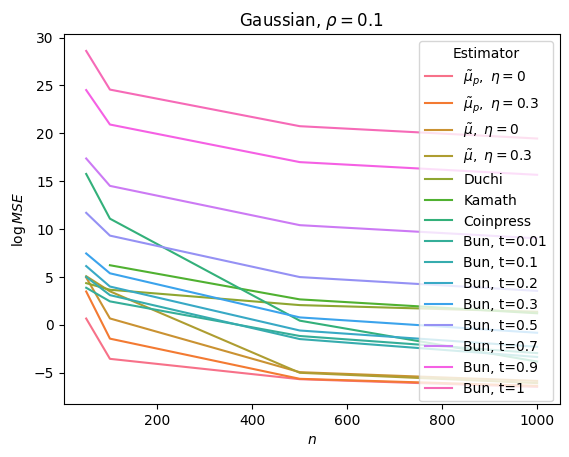

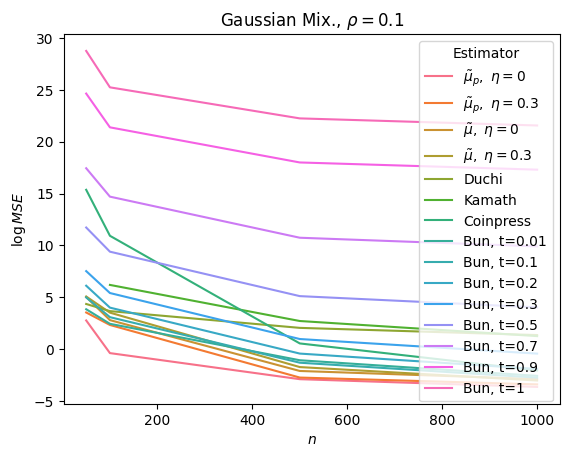

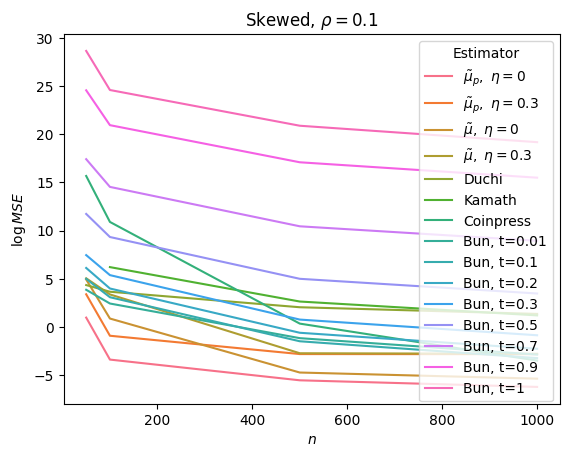

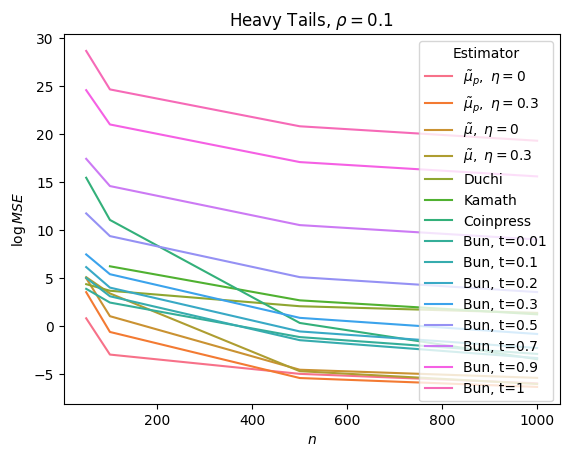

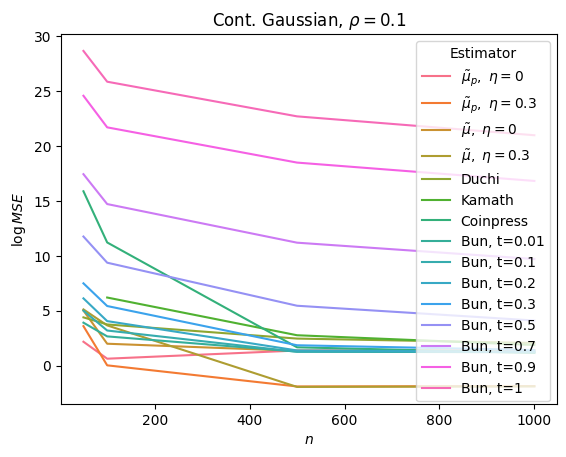

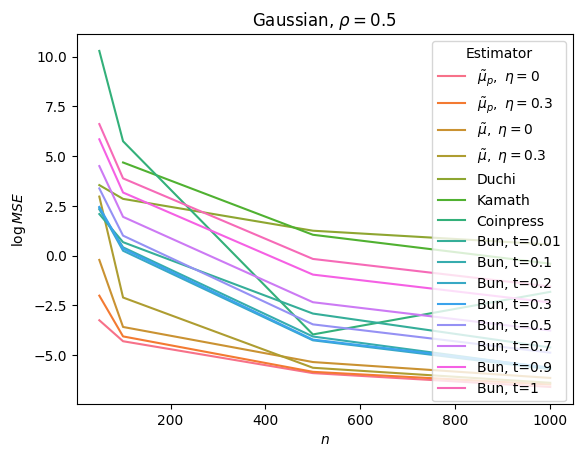

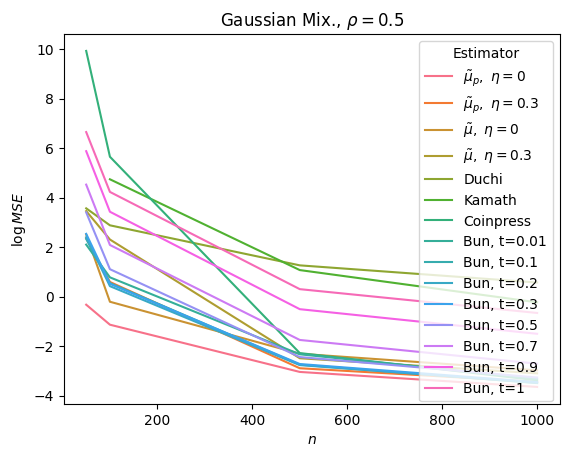

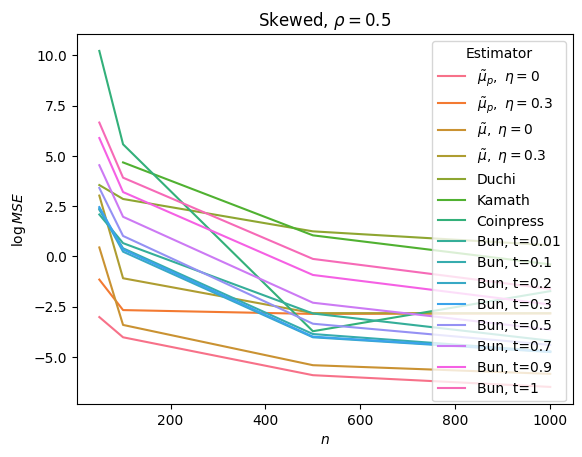

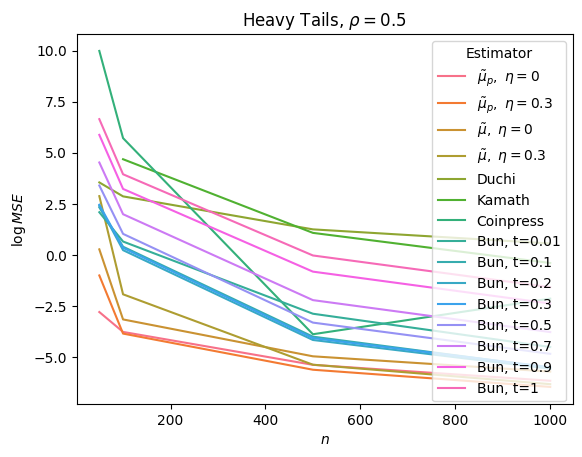

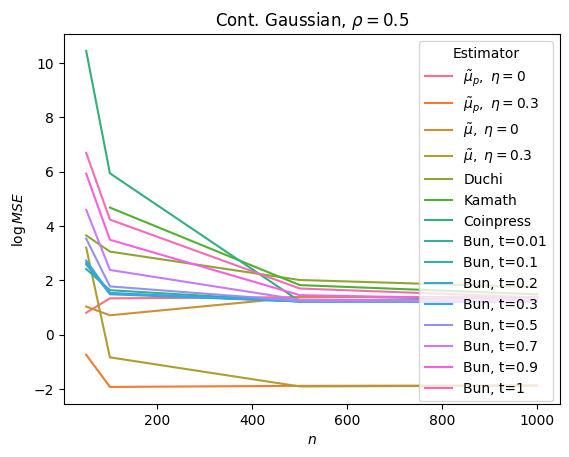

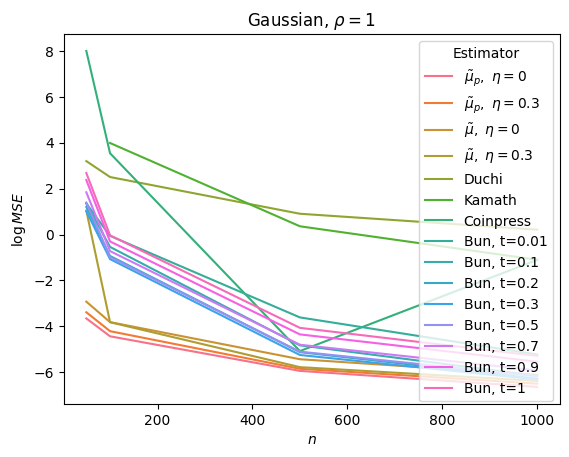

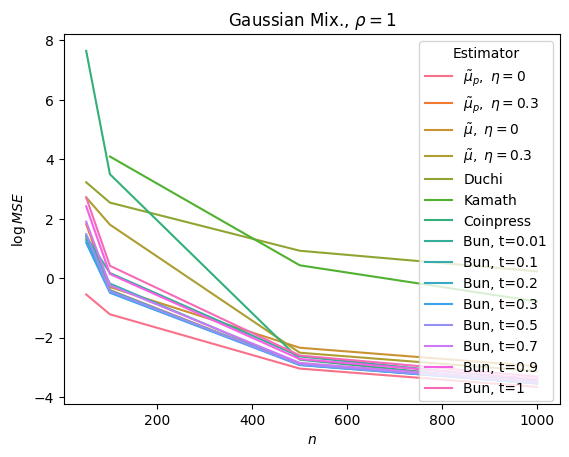

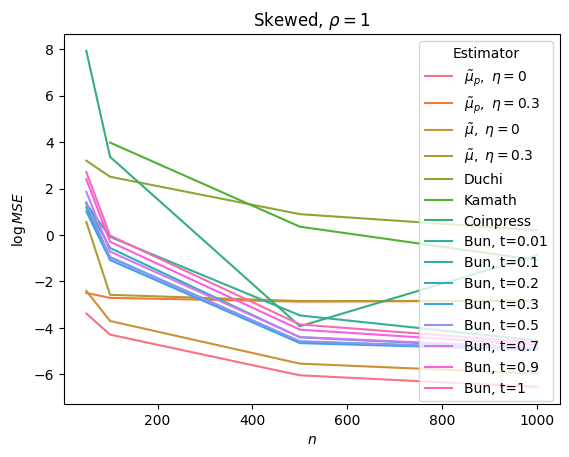

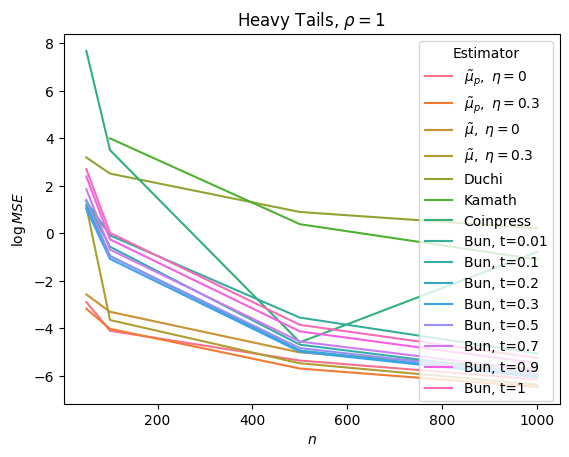

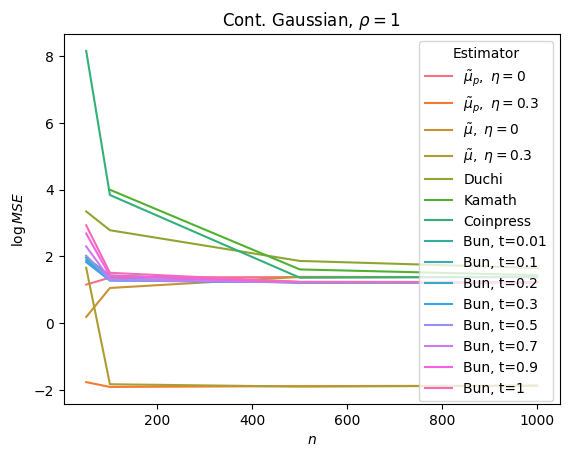

In [16]:








# now turn 4 columns into 1 
def make_plot(Type,rho,main):
    tmp=results_melted[results_melted['Type']==Type]
    tmp=tmp[tmp['rho']==rho]
    # print(tmp.head())
    tmp.dropna()
    sns.lineplot(data=tmp,y='lMSE',x='n',hue='Estimator')
    plt.title(main)
    plt.ylabel(r'$\log MSE$')
    plt.xlabel(r'$n$')
    plt.show()

for rho in rhos:
    for i in Types:
        make_plot(i,rho,main=dists[i-1]+r', $\rho=$'+str(rho))



# now turn 4 columns into 1 


# make_plot(1,1,(0,1))
# make_plot(2,1,(0,1))
# make_plot(3,1,(0,1))
# make_plot(4,1,(0,1))
# make_plot(5,1,(0,10))


# make_plot(1,10,(0,1))
# make_plot(2,10,(0,1))
# make_plot(3,10,(0,1))
# make_plot(4,10,(0,1))
# make_plot(5,10,(0,10))


# make_plot(1,100,(0,1))
# make_plot(2,100,(0,1))
# make_plot(3,100,(0,1))
# make_plot(4,100,(0,1))
# make_plot(5,100,(0,10))






# results_melted.head()
# results_melted.head(100)
# results_melted.MSE.unique()



In [17]:
# make_plot(1,10,(0,1/2))
# make_plot(2,10)
# make_plot(3,10)
# make_plot(4,10)
# make_plot(5,10)

In [18]:
sns.set_palette(['#ff0000', '#800000','#000000','#4c3e3e','#50C878','#228B22','magenta', 
                  '#87ceeb', '#4682b4', '#4682b4', '#4169e1', '#0000ff', '#0000cd', '#00008b', '#000080'])

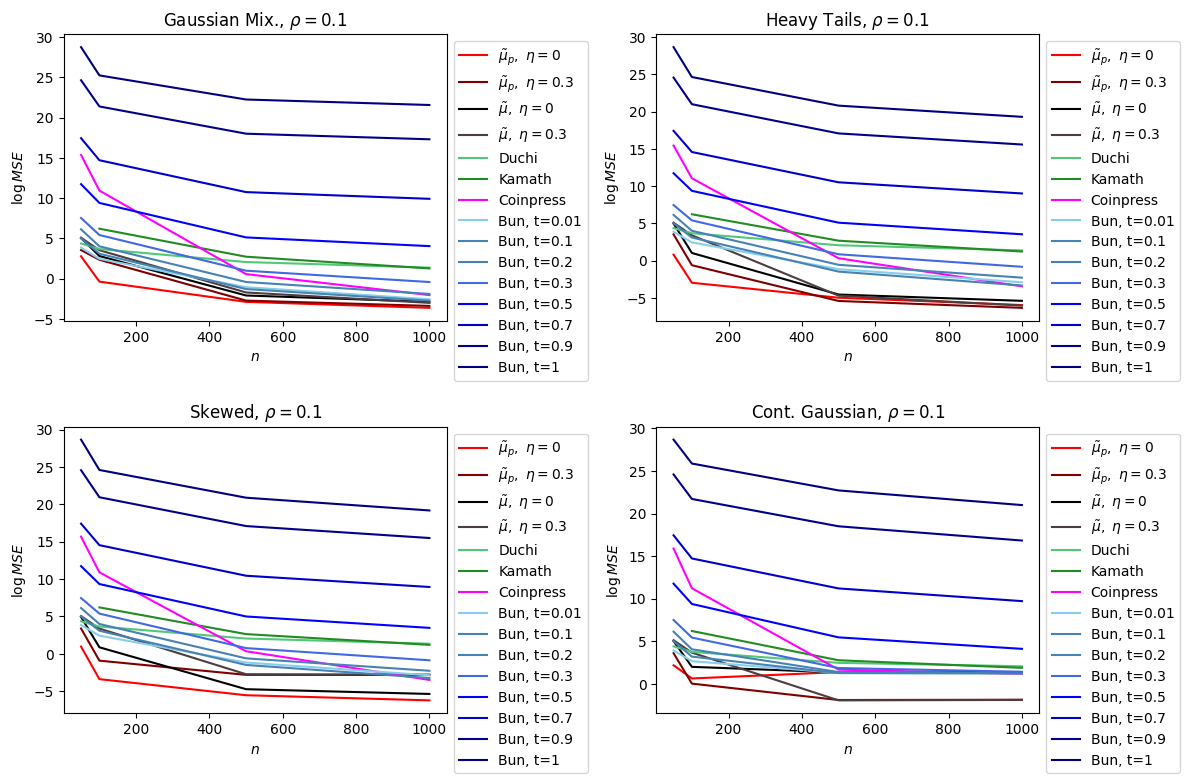

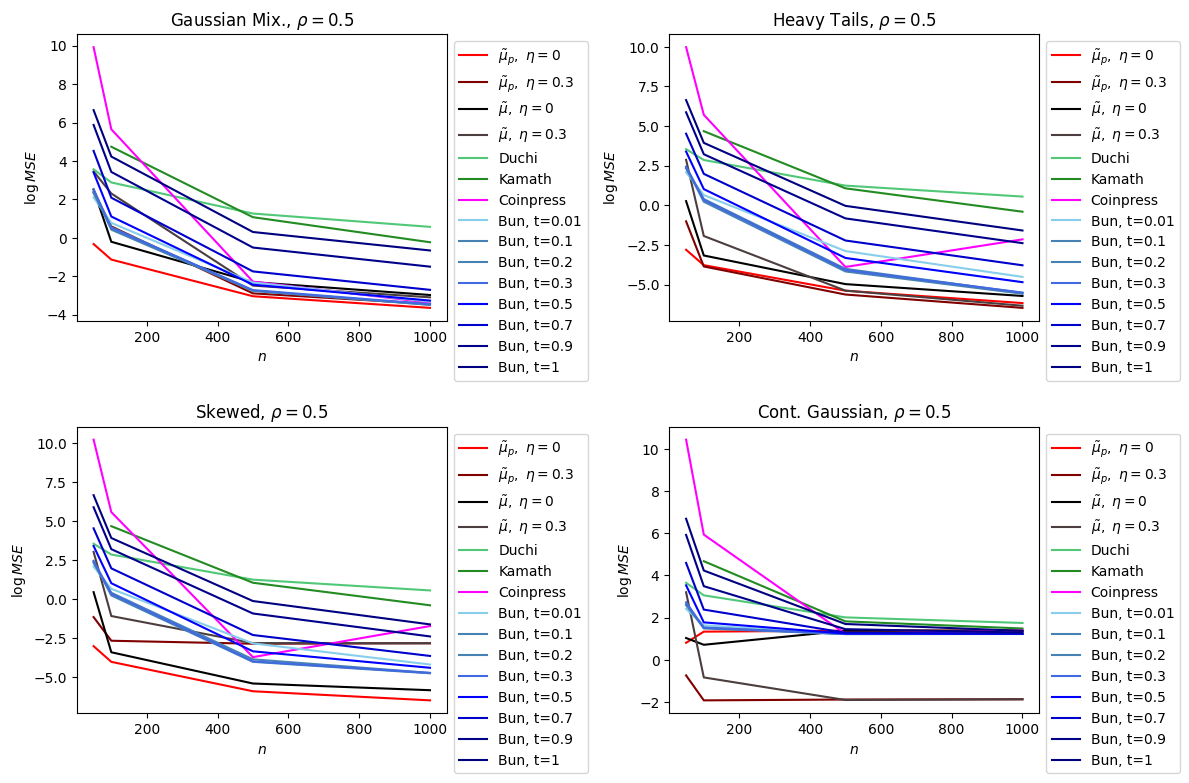

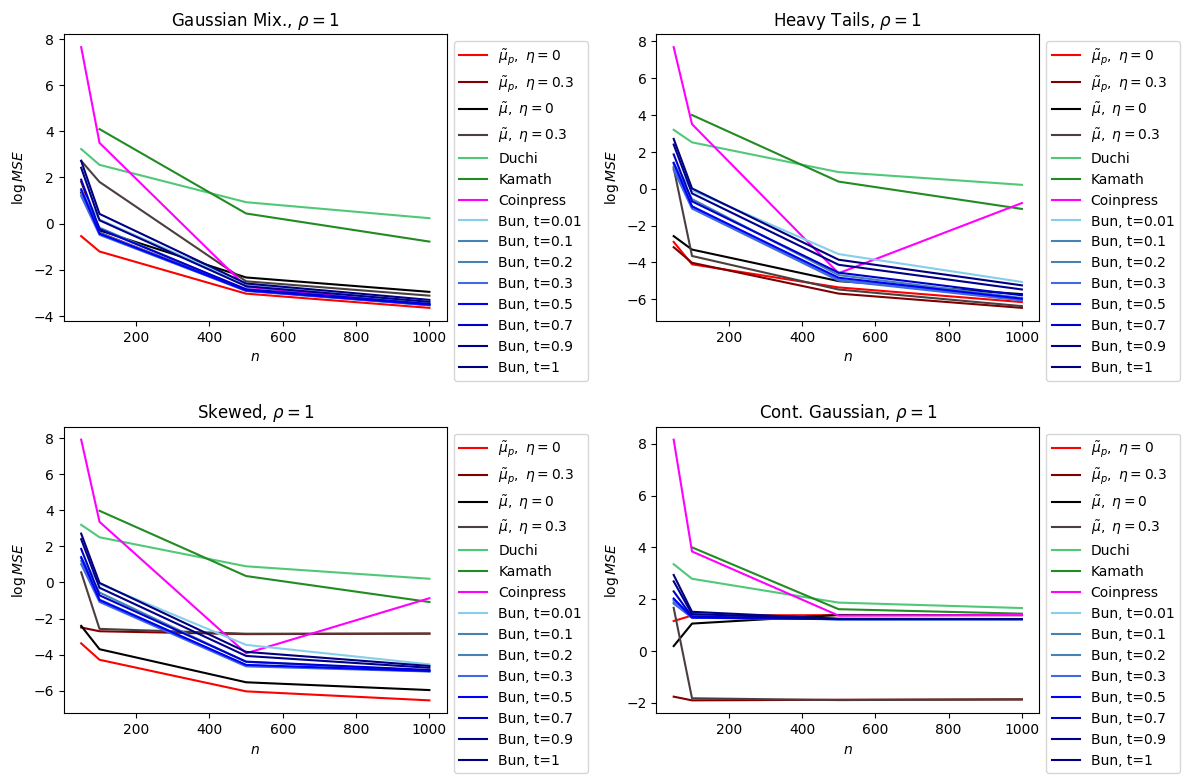

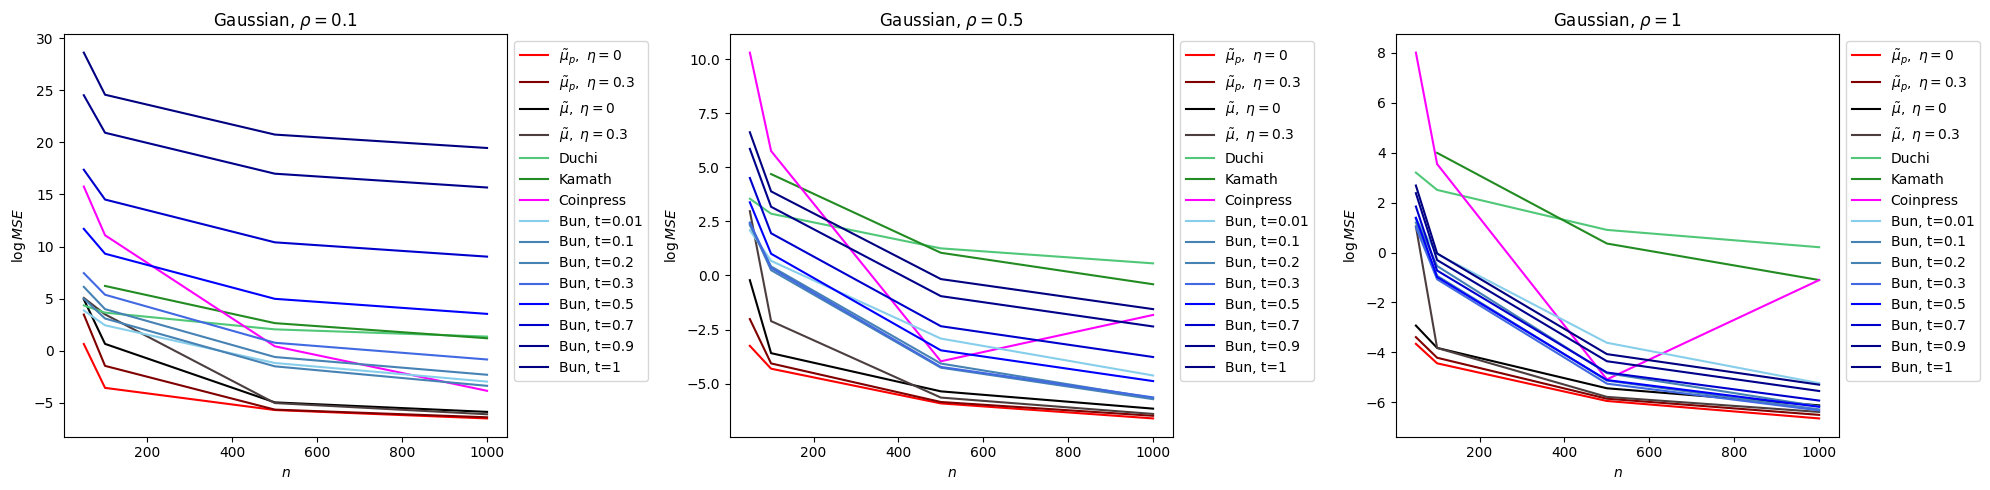

In [25]:


def make_plots():
    for rho in rhos:
        counta=0
        countb=0
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        for i in Types[1:5]:
            tmp=results_melted[results_melted['Type']==i]
            tmp=tmp[tmp['rho']==rho]
            # print(tmp.head())
            tmp.dropna()
            sns.lineplot(data=tmp,y='lMSE',x='n',hue='Estimator', ax=axes[counta, countb])
            axes[counta, countb].legend(loc='upper left', bbox_to_anchor=(1, 1))
            axes[counta, countb].set_title(dists[i-1]+r', $\rho=$'+str(rho))
            axes[counta, countb].set_ylabel(r'$\log MSE$')
            axes[counta, countb].set_xlabel(r'$n$')
            if counta<1:
                counta+=1
            elif counta==1 and countb==0:
                countb=1
                counta=0
            elif counta==0 and countb==1:
                counta+=1
        plt.tight_layout()
        fig.savefig("rho_"+str(rho)+".png")
        plt.show()
    count=0
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for rho in rhos:
        tmp=results_melted[results_melted['Type']==1]
        tmp=tmp[tmp['rho']==rho]
            # print(tmp.head())
        tmp.dropna()
        sns.lineplot(data=tmp,y='lMSE',x='n',hue='Estimator', ax=axes[count])
        axes[count].legend(loc='upper left', bbox_to_anchor=(1, 1))
        axes[count].set_title(dists[0]+r', $\rho=$'+str(rho))
        axes[count].set_ylabel(r'$\log MSE$')
        axes[count].set_xlabel(r'$n$')
        count+=1
    plt.tight_layout()
    fig.savefig("Gaussian_more_post.png")
    plt.show()



make_plots()



In [24]:
def make_plots():
    fig, axes = plt.subplots(5, 3, figsize=(10, 15))
    for j in range(3):
        rho=rhos[j]
        for i in range(5):
            tmp=results_melted[results_melted['Type']==(i+1)]
            tmp=tmp[tmp['rho']==rho]
            # print(tmp.head())
            tmp.dropna()
            sns.lineplot(data=tmp,y='lMSE',x='n',hue='Estimator', ax=axes[i,j])
            axes[i,j].set_title(dists[i]+r', $\rho=$'+str(rho))
            axes[i,j].set_ylabel(r'$\log MSE$')
            axes[i,j].set_xlabel(r'$n$')
    plt.tight_layout()
    # fig.savefig("rho_"+str(rho)+".png")
    plt.show()

# make_plots()


In [25]:


def make_plots():
    fig, axes = plt.subplots(5, 3, figsize=(10, 15))
    for j in range(3):
        rho=rhos[j]
        for i in range(5):
            tmp=results_melted[results_melted['Estimator']!='Kamath']
            tmp=tmp[tmp['Estimator']!='Duchi']
            tmp=tmp[tmp['Type']==(i+1)]
            tmp=tmp[tmp['rho']==rho]
            # print(tmp.head())
            tmp.dropna()
            sns.lineplot(data=tmp,y='lMSE',x='n',hue='Estimator', ax=axes[i,j])
            axes[i,j].set_title(dists[i]+r', $\rho=$'+str(rho))
            axes[i,j].set_ylabel(r'$\log MSE$')
            axes[i,j].set_xlabel(r'$n$')
            if (i+j)>0:
                axes[i,j].legend_.remove()
    plt.tight_layout()
    # fig.savefig("rho_"+str(rho)+".png")
    plt.show()
    
# make_plots()




In [26]:
results_melted['Estimator'].unique()

array(['$\\tilde \\mu_p,\\ \\eta=0$', '$\\tilde \\mu_p,\\ \\eta=0.3$',
       '$\\tilde \\mu,\\ \\eta=0$', '$\\tilde \\mu,\\ \\eta=0.3$',
       'Duchi', 'Kamath', 'Coinpress', 'Bun, t=0.01', 'Bun, t=0.1',
       'Bun, t=0.2', 'Bun, t=0.3', 'Bun, t=0.5', 'Bun, t=0.7',
       'Bun, t=0.9', 'Bun, t=1'], dtype=object)

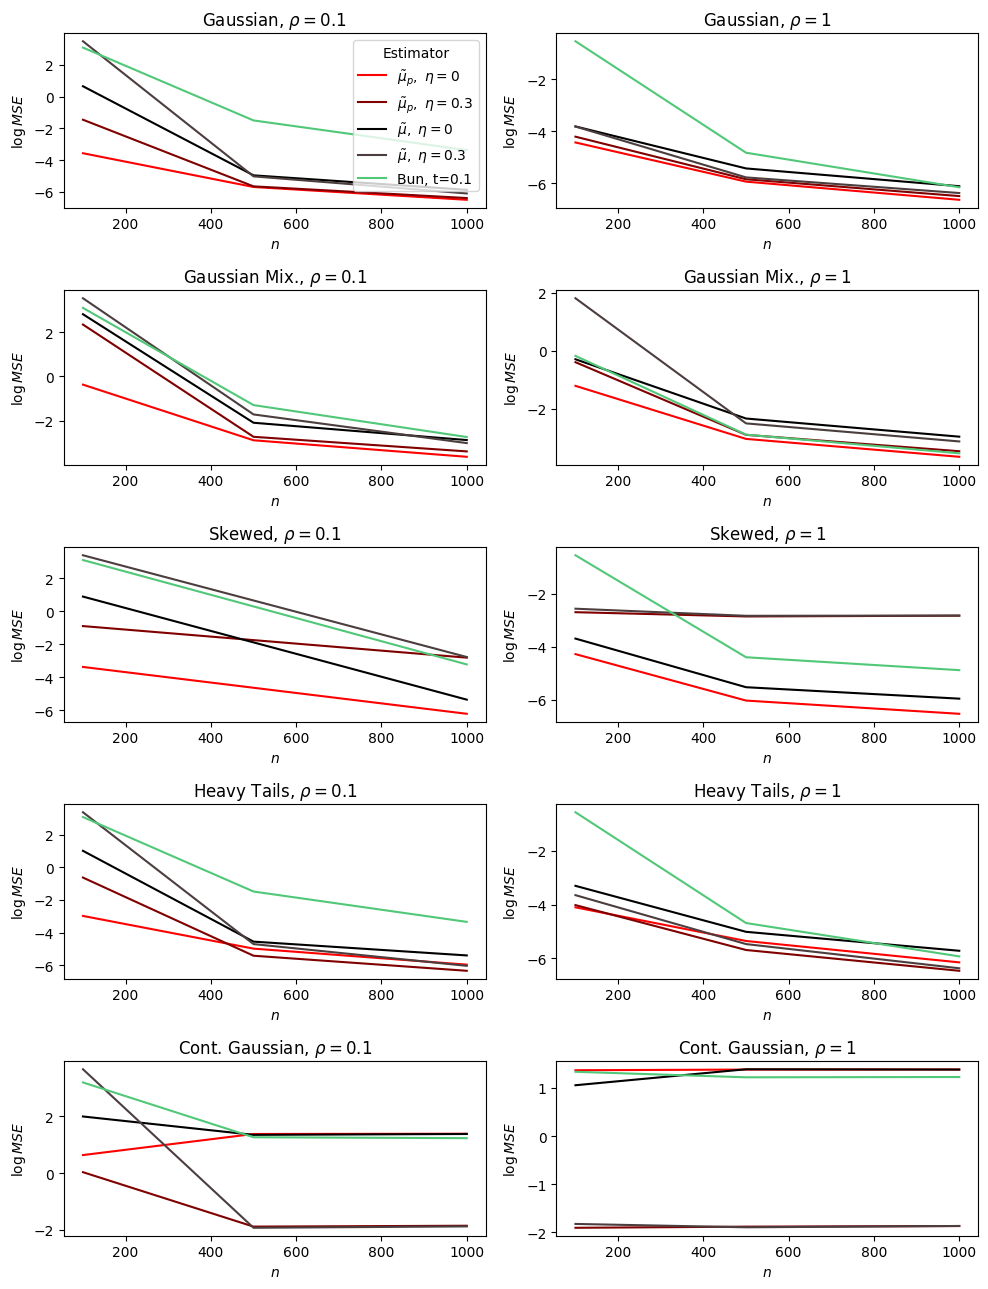

In [29]:
rhos2=[0.1,0.5,1]
#rho 0.5 doesnt add anything
rhos2=[0.1,1]
def make_plots():
    fig, axes = plt.subplots(5, 2, figsize=(10, 13))
    for j in [0,1]:
        rho=rhos2[j]
        if(rho==1):
            rho=int(rho)
        for i in range(5):
    #         tmp=results_melted[results_melted['Estimator'].isin(['$\\tilde \\mu,\\ \\eta=0$', '$\\tilde \\mu,\\ \\eta=0.3$',
    #    'Bun, t=0.01', 'Bun, t=1'])]
            tmp=results_melted[results_melted['Estimator'].isin(['$\\tilde \\mu,\\ \\eta=0$', 
                                                                 '$\\tilde \\mu,\\ \\eta=0.3$',
                                                                 '$\\tilde \\mu_p,\\ \\eta=0$', 
                                                                 '$\\tilde \\mu_p,\\ \\eta=0.3$',
                                                                 'Bun, t=0.1'])]
            # tmp=tmp[tmp['Estimator']!='Duchi']
            # tmp=tmp[tmp['Estimator']!='Duchi']
            # tmp=tmp[tmp['Estimator']!='Duchi']
            tmp=tmp[tmp['Type']==(i+1)]
            tmp=tmp[tmp['rho']==rho]
            if(rho<10):
                tmp=tmp[tmp['n']>50]
            # print(tmp.head())
            tmp.dropna()
            sns.lineplot(data=tmp,y='lMSE',x='n',hue='Estimator', ax=axes[i,j])
            axes[i,j].set_title(dists[i]+r', $\rho=$'+str(rho))
            # axes[i,j].set_ylabel(r'$\log MSE$')
            axes[i,j].set_ylabel(r'$\log MSE$')
            axes[i,j].set_xlabel(r'$n$')
            if (i+j)>0:
                axes[i,j].legend_.remove()
    plt.tight_layout()
    fig.savefig("manu_1.png")
    plt.show()
    
make_plots()


In [138]:

dists3={1: 'Gaussian',
       2: 'Gaussian Mix.',
       3: 'Skewed' ,
       4: 'Heavy Tails',
       5: 'Contam.'}
results_melted2['Distribution']


0           Gaussian
1      Gaussian Mix.
2             Skewed
3        Heavy Tails
4            Contam.
           ...      
355         Gaussian
356    Gaussian Mix.
357           Skewed
358      Heavy Tails
359          Contam.
Name: Distribution, Length: 360, dtype: object

In [33]:


results_melted2=results_melted
results_melted2['Distribution']=results_melted2['Type'].map(dists3)
results_melted2[r'$\rho$']=results_melted2['rho']
results_melted2=results_melted2.drop(columns=['Type','rho'])
new_df=results_melted2[results_melted2['Estimator'].isin(['$\\tilde \\mu,\\ \\eta=0$','Bun, t=0.1'])]
new_df_pt=new_df.pivot_table(values='MSE',columns=['n','Estimator'],index=[r'$\rho$','Distribution']).reset_index()
new_df_pt

NameError: name 'dists3' is not defined

In [31]:
results_melted2['Distribution'].unique()

KeyError: 'Distribution'

In [32]:
# new_df=results_melted2[results_melted2['Estimator'].isin(['$\\tilde \\mu,\\ \\eta=0$','Bun, t=1'])]
# new_df_pt=new_df.pivot_table(values='MSE',columns=['n','Estimator'],index=[r'$\rho$','Distribution']).reset_index()
# new_df_pt2=new_df_pt.round(4)
# latex_table =new_df_pt2.to_latex( float_format="%.3f")
# # print(latex_table)


results_melted3=results_melted2
new_df=results_melted3[results_melted3['Estimator'].isin(['$\\tilde \\mu,\\ \\eta=0$','Bun, t=1'])]
new_df_pt=new_df.pivot_table(values='MSE',columns=['n','Estimator'],index=[r'$\rho$','Distribution']).reset_index()
new_df_pt2=new_df_pt.round(4)
latex_table =new_df_pt2.to_latex( index=False,float_format="%.3f")
print(latex_table)


# results_melted3=results_melted2[results_melted2['n']>=500]
# new_df=results_melted3[results_melted3['Estimator'].isin(['$\\tilde \\mu,\\ \\eta=0$','Bun, t=1'])]
# new_df_pt=new_df.pivot_table(values='MSE',columns=['n','Estimator'],index=[r'$\rho$','Distribution']).reset_index()
# new_df_pt2=new_df_pt.round(4)
# latex_table =new_df_pt2.to_latex(index=False, float_format="%.3f")
# print(latex_table)

KeyError: '$\\rho$'